<a href="https://colab.research.google.com/github/J-Lehrer/aai_540_group_2_final_project/blob/main/InstantCart_Project_GXboost_and_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary libraries

In [ ]:
! pip install pyathena

  Using cached botocore-1.34.162-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.162-py3-none-any.whl (12.5 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.36.3
    Uninstalling botocore-1.36.3:
      Successfully uninstalled botocore-1.36.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.33.13 requires botocore==1.34.131, but you have botocore 1.34.162 which is incompatible.
aiobotocore 2.19.0 requires botocore<1.36.4,>=1.36.0, but you have botocore 1.34.162 which is incompatible.


In [ ]:
!pip install awswrangler

In [ ]:
!pip install seaborn

In [ ]:
!pip install --upgrade s3fs aiobotocore botocore



  Using cached botocore-1.36.16-py3-none-any.whl.metadata (5.7 kB)
  Using cached botocore-1.36.3-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.36.3-py3-none-any.whl (13.3 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.162
    Uninstalling botocore-1.34.162:
      Successfully uninstalled botocore-1.34.162
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.33.13 requires botocore==1.34.131, but you have botocore 1.36.3 which is incompatible.
boto3 1.34.131 requires botocore<1.35.0,>=1.34.131, but you have botocore 1.36.3 which is incompatible.


In [ ]:
import s3fs
import botocore

print(f"s3fs version: {s3fs.__version__}")
print(f"botocore version: {botocore.__version__}")


s3fs version: 2025.2.0
botocore version: 1.36.3


## Importing necessary libraries

In [ ]:
from pyathena import connect

In [ ]:
import awswrangler as wr
import pandas as pd


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Converting InstantCart CSV dataset into Parquet

In [ ]:
csv_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/filtered_frequent_buyers_v1.csv"
df = pd.read_csv(csv_path)
# Loading CSV from S3

train_df, remaining_df = train_test_split(df, train_size=0.4, random_state=42)

# Split the remaining data into production and temp datasets (66% production, 33% temp)
production_df, temp_df = train_test_split(remaining_df, train_size=0.666666, random_state=42)

# Split the temp data into test and validation datasets (50% test, 50% validation)
test_df, validation_df = train_test_split(temp_df, train_size=0.5, random_state=42)

In [ ]:
# Defining S3 paths
parquet_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/"


# Save each split dataset to Parquet with partitioning by 'department'
wr.s3.to_parquet(
    df=train_df,
    path=parquet_output_path + "train/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

wr.s3.to_parquet(
    df=production_df,
    path=parquet_output_path + "production/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

wr.s3.to_parquet(
    df=test_df,
    path=parquet_output_path + "test/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

wr.s3.to_parquet(
    df=validation_df,
    path=parquet_output_path + "validation/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)




{'paths': ['s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=bakery/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=beverages/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=canned goods/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=dairy eggs/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=deli/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=dry goods pasta/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-9219168

In [ ]:
# Create the database if it doesn't exist
database_name = "instacart_db_split"
try:
    # Create the database in AWS Glue
    wr.catalog.create_database(name=database_name)
    print(f"Database '{database_name}' created successfully!")
except Exception as e:
    print(f"Error creating database: {e}")

Database 'instacart_db_split' created successfully!


In [ ]:
# Register the Parquet tables in AWS Glue
table_name = "instacart_orders"

wr.catalog.create_parquet_table(
    database=database_name,
    table=table_name,
    path=parquet_output_path + "train/",
    columns_types={
        "order_id": "bigint",
        "product_id": "bigint",
        "add_to_cart_order": "int",
        "reordered": "int",
        "user_id": "bigint",
        "product_name": "string",
        "aisle_id": "int",
        "department_id": "int",
        "aisle": "string",
        "department": "string"
    },
    partitions_types={"department": "string"},
    description="Partitioned Instacart orders dataset for optimized Athena queries."
)

print("Partitioned Parquet table registered in AWS Glue successfully.")


Partitioned Parquet table registered in AWS Glue successfully.


# Setting up Database for InstantCart

In [ ]:
from pyathena import connect

# Defineing AWS Resources
bucket_name = "sagemaker-us-east-1-921916832724"
region = "us-east-1"
database_name = "instacart_db_split"
table_name = "instacart_orders"
s3_data_location = f"s3://{bucket_name}/data-lake/Project/partitioned_split/train/"  # Using partitioned dataset

# Defining Athena Staging Directory
s3_staging_dir = f"s3://{bucket_name}/athena/instacart_staging_split/"

# Creating Athena Connection
try:
    conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)
    cursor = conn.cursor()
    print("Connected to Athena successfully.")
except Exception as e:
    print("Error connecting to Athena:", e)

# Creating Database
create_db_query = f"CREATE DATABASE IF NOT EXISTS {database_name}"
cursor.execute(create_db_query)
print(f"Database '{database_name}' created successfully!")

# Verifying Database Creation
cursor.execute("SHOW DATABASES")
databases = [row[0] for row in cursor.fetchall()]
if database_name in databases:
    print(f"Database '{database_name}' exists!")


Connected to Athena successfully.
Database 'instacart_db_split' created successfully!
Database 'instacart_db_split' exists!


DROP TABLE instacart_db_split.instacart_orders;
# Creating Athena database

In [ ]:
# Define the SQL query to create the table
create_table_query = """
CREATE EXTERNAL TABLE IF NOT EXISTS instacart_db_split.instacart_orders (
    order_id BIGINT,
    product_id BIGINT,
    add_to_cart_order INT,
    reordered INT,
    user_id BIGINT,
    product_name STRING,
    aisle_id INT,
    department_id INT,
    aisle STRING
)
PARTITIONED BY (department STRING)  -- Partitioned by department
STORED AS PARQUET
LOCATION 's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/'
TBLPROPERTIES ('parquet.compression'='SNAPPY');
"""

# Execute the SQL query in Athena
cursor.execute(create_table_query)
print("Table 'instacart_orders' created successfully in database 'instacart_db_split'.")



Table 'instacart_orders' created successfully in database 'instacart_db_split'.


In [ ]:

# Running MSCK REPAIR to Load Partitions
cursor.execute(f"MSCK REPAIR TABLE {database_name}.{table_name}")
print("Partitions updated successfully.")

Partitions updated successfully.


In [ ]:
cursor.execute("SHOW DATABASES")
databases = [row[0] for row in cursor.fetchall()]
if database_name in databases:
    print(f"Database '{database_name}' exists in Athena!")
else:
    print(f"Database '{database_name}' does not exist.")


Database 'instacart_db_split' exists in Athena!


In [ ]:
import boto3

s3 = boto3.client('s3')
response = s3.list_objects_v2(Bucket='sagemaker-us-east-1-921916832724', Prefix='data-lake/Project/partitioned_split/train/')
for obj in response.get('Contents', []):
    print(obj['Key'])


data-lake/Project/partitioned_split/train/department=bakery/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=beverages/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=canned goods/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=dairy eggs/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=deli/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=dry goods pasta/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=frozen/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=pantry/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=produce/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-la

In [ ]:
# Running a Sample Query to Verify Data
test_query = f"SELECT count(*) FROM {database_name}.{table_name} ;"
cursor.execute(test_query)
rows = cursor.fetchall()

print("Sample Query Results:")
for row in rows:
    print(row)

Sample Query Results:
(3035258,)


In [ ]:
cursor.execute(f"SHOW PARTITIONS {database_name}.{table_name}")
partitions = cursor.fetchall()
if partitions:
    print(f"Partitions found in table '{table_name}': {partitions}")
else:
    print(f"No partitions found in table '{table_name}'.")


Partitions found in table 'instacart_orders': [('department=produce',), ('department=dairy eggs',), ('department=snacks',), ('department=deli',), ('department=frozen',), ('department=pantry',), ('department=beverages',), ('department=canned goods',), ('department=bakery',), ('department=dry goods pasta',)]


# Exploratory Data Analysis in the training set

## Checking the Total Orders and Unique Users

In [ ]:

# First Query: Total Orders & Unique Users
query = f"""
SELECT
    COUNT(DISTINCT order_id) AS total_orders,
    COUNT(DISTINCT user_id) AS unique_users
FROM {database_name}.{table_name};
"""

# Executing query
cursor.execute(query)
rows = cursor.fetchall()

# Printing results
print("Total Orders & Unique Users:")
for row in rows:
    print(row)


Total Orders & Unique Users:
(552593, 11033)


## Top 10 Most Ordered Products


In [ ]:
query = f"""
SELECT product_name, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY product_name
ORDER BY total_orders DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Most Ordered Products:")
for row in rows:
    print(row)


Top 10 Most Ordered Products:
('Banana', 52073)
('Bag of Organic Bananas', 46964)
('Organic Strawberries', 39311)
('Organic Hass Avocado', 31555)
('Organic Baby Spinach', 29459)
('Organic Raspberries', 21479)
('Organic Avocado', 19582)
('Organic Whole Milk', 19211)
('Limes', 17136)
('Large Lemon', 16719)


/tmp/ipykernel_234/1557864825.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Product Name", data=df_products, palette="viridis")


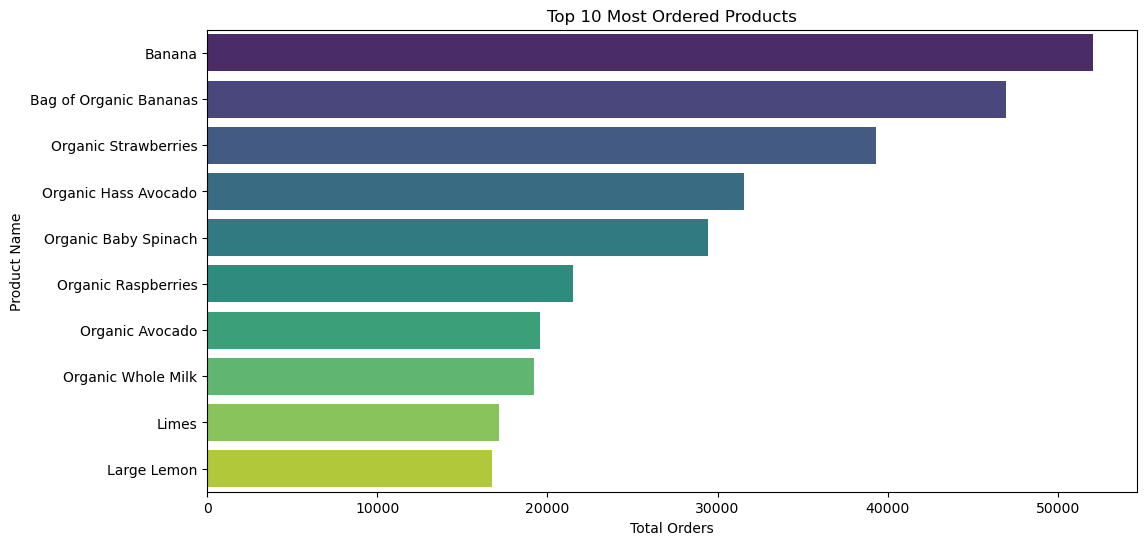

In [ ]:
# ===========================
#  Bar Chart: Top 10 Most Ordered Products
# ===========================

products = ["Banana", "Bag of Organic Bananas", "Organic Strawberries", "Organic Hass Avocado",
            "Organic Baby Spinach", "Organic Raspberries", "Organic Avocado", "Organic Whole Milk",
            "Limes", "Large Lemon"]
total_orders = [52073, 46964, 39311, 31555, 29459, 21479, 19582, 19211, 17136, 16719]

# Creating DataFrame
df_products = pd.DataFrame({"Product Name": products, "Total Orders": total_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Product Name", data=df_products, palette="viridis")
plt.xlabel("Total Orders")
plt.ylabel("Product Name")
plt.title("Top 10 Most Ordered Products")
plt.show()


### Insights

- Bananas are the most ordered item with 52073 orders.
- Organic produce is extremely popular. Where 7 out of 10 items are organic.
- Dairy products like Whole Milk rank in the Top 10.
- Cirtrus fruits like Limes and Lemons are in high demand.

## Reorder Rate per Product

In [ ]:
query = f"""
SELECT
    product_name,
    COUNT(*) AS total_orders,
    SUM(reordered) AS total_reorders,
    ROUND(100.0 * SUM(reordered) / COUNT(*), 2) AS reorder_rate
FROM {database_name}.{table_name}
GROUP BY product_name
ORDER BY reorder_rate DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Products with Highest Reorder Rate:")
for row in rows:
    print(row)


Top 10 Products with Highest Reorder Rate:
('Salted Sweet Cream Butter Quarters', 1, 1, 100.0)
('Green Bananas', 3, 3, 100.0)
('Premium Lots of Pulp Orange Juice', 6, 6, 100.0)
('Sparkling Water, Bottles', 3, 3, 100.0)
('100% Lactose Free Milk', 6, 6, 100.0)
('Peru Sweet Onions', 2, 2, 100.0)
('Smoked Whitefish Salad', 33, 33, 100.0)
('Seltzer Water', 15, 15, 100.0)
('Thirst Quencher Caffeine Free Naturally Flavored Citrus Soda', 28, 28, 100.0)
('Classic Baby Creamers Potatoes', 7, 7, 100.0)


### Insights for Top 10 Products with Highest Reorder Rate:

- **100% Lactose-Free Milk** has a **100% reorder rate**, indicating it is a highly demanded product among lactose-intolerant customers who consistently reorder it.
- **Salted Sweet Cream Butter Quarters**, **Sparkling Water Bottles**, and **Premium Lots of Pulp Orange Juice** also show a **100% reorder rate**, signifying that these are popular products with strong customer loyalty and recurring demand.
- **Classic Baby Creamers Potatoes** and **Peru Sweet Onions** are products with **100% reorder rate**, pointing to their continued preference and high re-purchase frequency among customers.
- **Thirst Quencher Caffeine-Free Naturally Flavored Citrus Soda** and **Smoked Whitefish Salad** reflect **100% reorder rates**, highlighting that these items are consistently chosen by customers who keep coming back for more.
- **Seltzer Water** and **Green Bananas** demonstrate high reorder demand, each maintaining **100% reorder rate**, suggesting these are staple items that customers rely on regularly.

## Orders by Department

In [ ]:
query = f"""
SELECT department, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY department
ORDER BY total_orders DESC;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Orders by Department:")
for row in rows:
    print(row)


Orders by Department:
('produce', 1116850)
('dairy eggs', 619999)
('snacks', 294213)
('beverages', 234613)
('frozen', 201359)
('pantry', 138924)
('bakery', 127884)
('deli', 114349)
('canned goods', 102416)
('dry goods pasta', 84651)


/tmp/ipykernel_234/1099213901.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Department", data=df_orders_by_department, palette="magma")


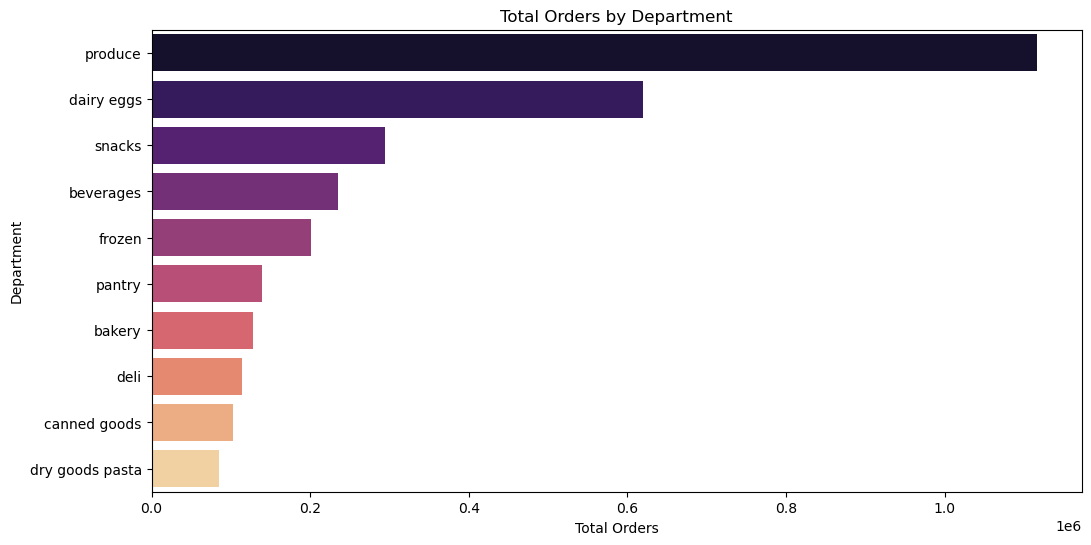

In [ ]:
# ===========================
# Bar Chart: Orders by Department
# ===========================

# Data from previous query (Department, Total Orders)
departments = ["produce", "dairy eggs", "snacks", "beverages", "frozen",
               "pantry", "bakery", "deli", "canned goods", "dry goods pasta"]
total_orders = [1116850, 619999, 294213, 234613, 201359, 138924, 127884, 114349, 102416, 84651]

# Creating DataFrame
df_orders_by_department = pd.DataFrame({"Department": departments, "Total Orders": total_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Department", data=df_orders_by_department, palette="magma")
plt.xlabel("Total Orders")
plt.ylabel("Department")
plt.title("Total Orders by Department")
plt.show()


### Insights

- Produce is the most ordered department with ~1.11 million orders. This aligns with the earlier Top Ordered Products (bananas, avocados, berries). On another hand, Fresh produce is frequently bought and likely reordered often.
- Dairy & Eggs ranks second with 619K orders.
- Snacks are the third most popular category (294K orders).
    - Expect chips, granola bars, and nuts to dominate.
- Beverages & Frozen Foods also have strong demand.
    - Beverages (~234K orders) likely include popular items like bottled water, juices, and coffee.
    - Frozen Foods (~201K orders) suggest customers stock up on frozen essentials.
- Pantry Staples, Bakery, and Deli also contribute significantly. It could likely contain bread, canned goods, and dry pasta.

## Most Popular Aisles

In [ ]:
query = f"""
SELECT aisle, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY aisle
ORDER BY total_orders DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Aisles:")
for row in rows:
    print(row)


Top 10 Aisles:
('fresh fruits', 450026)
('fresh vegetables', 404252)
('packaged vegetables fruits', 205492)
('yogurt', 184903)
('packaged cheese', 112690)
('milk', 103953)
('water seltzer sparkling water', 78019)
('chips pretzels', 74536)
('soy lactosefree', 68786)
('bread', 65469)


/tmp/ipykernel_234/4010282009.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Aisle", data=df_aisles, palette="coolwarm")


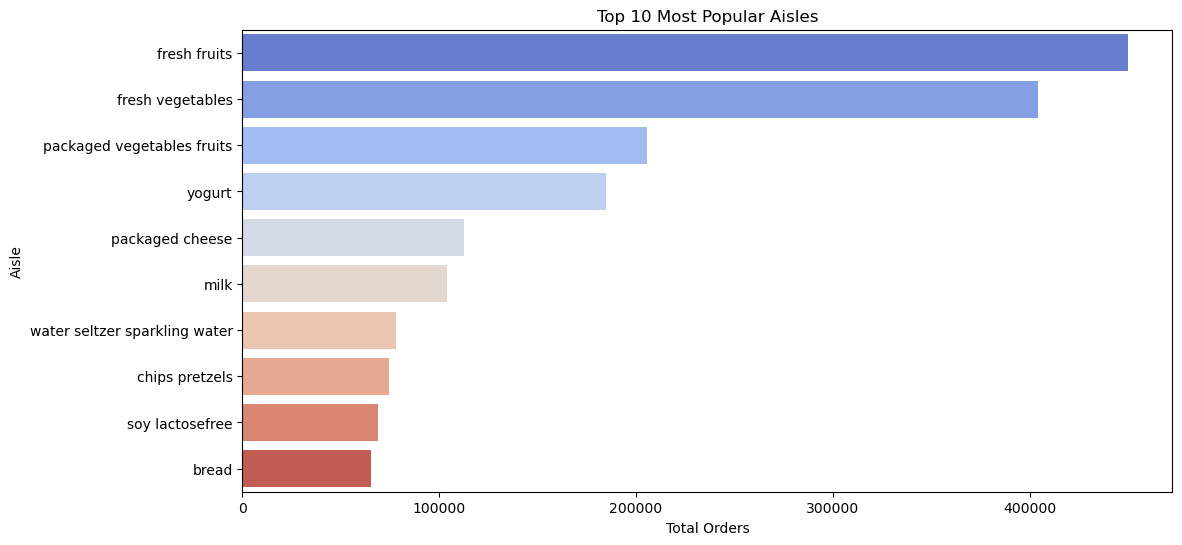

In [ ]:
# ===========================
# Bar Chart: Most Popular Aisles
# ===========================

# Data from previous query (Aisle, Total Orders)
aisles = ["fresh fruits", "fresh vegetables", "packaged vegetables fruits", "yogurt",
          "packaged cheese", "milk", "water seltzer sparkling water", "chips pretzels",
          "soy lactosefree", "bread"]
aisle_orders = [450026, 404252, 205492, 184903, 112690, 103953, 78019, 74536, 68786, 65469]

# Creating DataFrame
df_aisles = pd.DataFrame({"Aisle": aisles, "Total Orders": aisle_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Aisle", data=df_aisles, palette="coolwarm")
plt.xlabel("Total Orders")
plt.ylabel("Aisle")
plt.title("Top 10 Most Popular Aisles")
plt.show()

### Insights
- Fresh Produce Dominance:
    - Fresh Fruits (450K orders) and Fresh Vegetables (404K orders) are the top two aisles.
    - Combined, these two alone account for over 950K orders, which reinforces why Produce is the top department.

- Dairy is Highly Popular:
    - Yogurt (184K orders) and Packaged Cheese (112K orders) show strong demand.
    - Milk (103K orders) further confirms that dairy products are household essentials.

- Beverages are a Major Category:
    - Water, Seltzer, and Sparkling Water (78K orders) ranks #7, showing strong demand for bottled drinks.

- Snacks & Bread are Key Pantry Items
    - Chips & Pretzels (74K orders) are among the most frequently purchased snacks.
    - Bread (65K orders) confirms why Bakery is among the top departments.

- Plant-Based Alternatives are Growing
    - Soy & Lactose-Free Products (68K orders) indicate increased demand for dairy-free alternatives.

##  Reorder Ratio by Department

In [ ]:
query = f"""
SELECT
    department,
    COUNT(*) AS total_orders,
    SUM(reordered) AS total_reorders,
    ROUND(100.0 * SUM(reordered) / COUNT(*), 2) AS reorder_ratio
FROM {database_name}.{table_name}
GROUP BY department
ORDER BY reorder_ratio DESC;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Reorder Ratio by Department:")
for row in rows:
    print(row)


Reorder Ratio by Department:
('dairy eggs', 619999, 512956, 82.73)
('beverages', 234613, 189692, 80.85)
('produce', 1116850, 901358, 80.71)
('bakery', 127884, 102853, 80.43)
('deli', 114349, 89802, 78.53)
('snacks', 294213, 217758, 74.01)
('frozen', 201359, 144719, 71.87)
('canned goods', 102416, 67094, 65.51)
('dry goods pasta', 84651, 55299, 65.33)
('pantry', 138924, 79541, 57.26)


### Insights

- Dairy & Eggs Have the Highest Reorder Rate (82.73%)
    - Most frequently reordered category.
    - Milk, Yogurt, and Cheese are household staples → high repurchase behavior.

- Beverages Rank #2 in Reorders (80.85%)
    - Bottled Water, Sparkling Water, and Coffee/Tea are commonly repurchased.
    - These items are frequently consumed & replaced regularly.

- Produce Has a High Reorder Rate (80.71%)
    - Fruits and vegetables have a high purchase frequency.
    - Bananas, Avocados, and Berries from previous queries reinforce this trend.

- Bakery (80.43%) & Deli (78.53%) Show Strong Reorder Loyalty
    - Bread, Bagels, and Pre-packaged Deli Items are regularly bought items.
    - Customers often stick to the same brands.

- Snacks & Frozen Foods Have Moderate Reorder Rates (~70%)
    - Chips, Pretzels, and Frozen Meals are repurchased but less frequently than fresh foods.

- Canned Goods & Dry Goods Have Lower Reorder Rates (~65%)
    - Longer shelf life → not purchased as frequently.

- Pasta, sauces, and canned vegetables last longer → lower immediate repurchase need.

- Pantry Has the Lowest Reorder Rate (57.26%)
    - Less frequent purchases of pantry staples like flour, condiments, and spices.

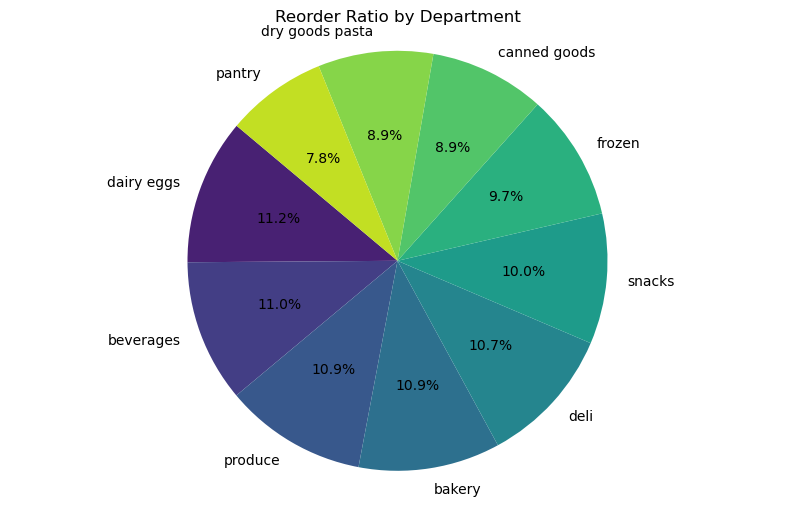

In [ ]:
# ===========================
# Pie Chart: Reorder Ratio by Department
# ===========================

# Data from previous query (Department, Reorder Ratio)
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
reorder_ratio = [82.73, 80.85, 80.71, 80.43, 78.53, 74.01, 71.87, 65.51, 65.33, 57.26]

# Create DataFrame
df_departments = pd.DataFrame({"Department": departments, "Reorder Ratio": reorder_ratio})

# Plot Pie Chart
plt.figure(figsize=(10, 6))
plt.pie(df_departments["Reorder Ratio"], labels=df_departments["Department"],
        autopct="%1.1f%%", colors=sns.color_palette("viridis", len(departments)), startangle=140)
plt.title("Reorder Ratio by Department")
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()

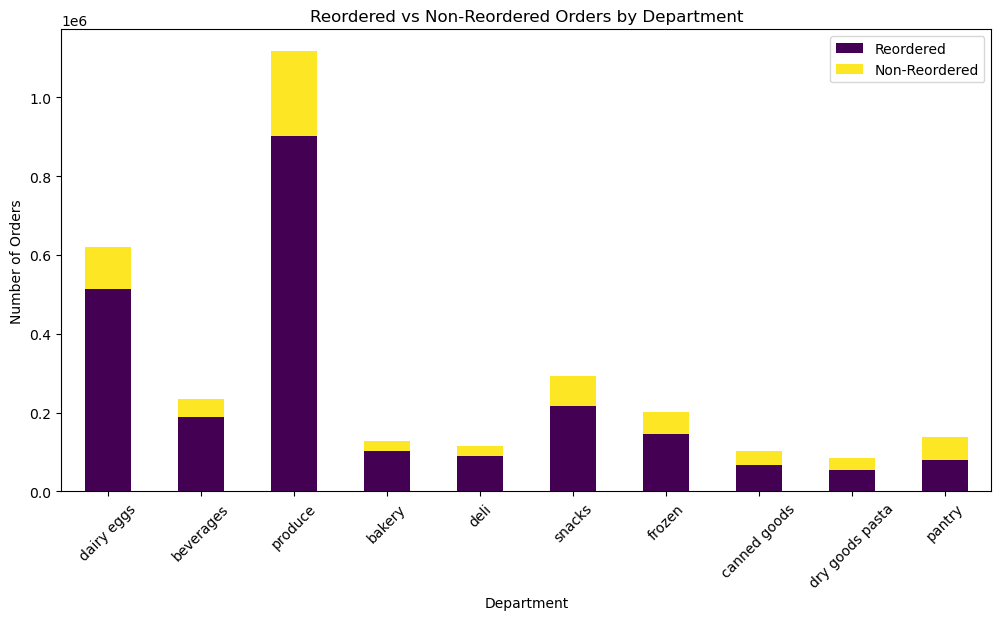

In [ ]:
# ===========================
# Stacked Bar Chart: Reordered vs Non-Reordered Orders by Department
# ===========================

# Data from previous query (Department, Reordered Orders)
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
total_orders = [619999, 234613, 1116850, 127884, 114349, 294213, 201359, 102416, 84651, 138924]
reordered = [512956, 189692, 901358, 102853, 89802, 217758, 144719, 67094, 55299, 79541]
non_reordered = [total - reorder for total, reorder in zip(total_orders, reordered)]

# Create DataFrame
df_reorders = pd.DataFrame({"Department": departments, "Reordered": reordered, "Non-Reordered": non_reordered})

# Plot Stacked Bar Chart (Reordered vs Non-Reordered)
df_reorders.set_index("Department")[["Reordered", "Non-Reordered"]].plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.xlabel("Department")
plt.ylabel("Number of Orders")
plt.title("Reordered vs Non-Reordered Orders by Department")
plt.legend(["Reordered", "Non-Reordered"])
plt.xticks(rotation=45)
plt.show()

**Analysis for reordered vs non-reordered orders by department**:
    
1. Produce has the highest number of orders overall

    - Most of these orders are reorders, confirming that fruits and vegetables are frequently repurchased.

2. Dairy & Eggs have the highest reorder percentage
    - Consistently repurchased products like milk, cheese, and yogurt drive these numbers.

3. Snacks and Frozen Foods have moderate reorder levels
    - Customers repurchase snacks and frozen goods but at a slightly lower frequency than fresh items.

4. Pantry and Canned Goods have the lowest reorder rates
    - These products have a longer shelf life, reducing the need for frequent repurchasing.

## Correlation Analysis

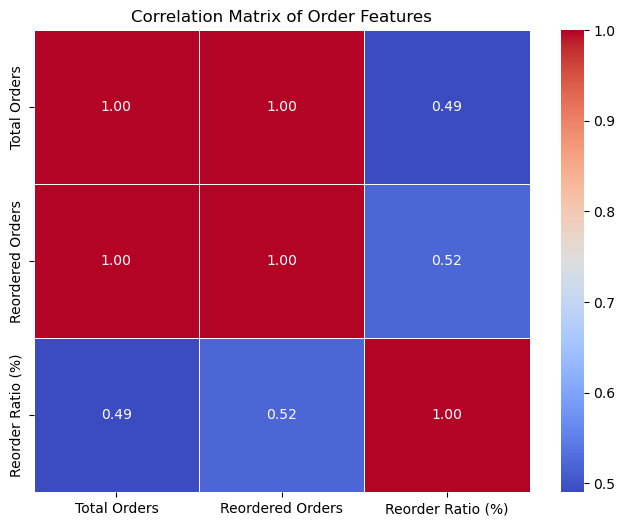

In [ ]:
# Data: Numerical Features for Correlation Analysis
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
total_orders = [619999, 234613, 1116850, 127884, 114349, 294213, 201359, 102416, 84651, 138924]
reordered = [512956, 189692, 901358, 102853, 89802, 217758, 144719, 67094, 55299, 79541]
reorder_ratio = [82.73, 80.85, 80.71, 80.43, 78.53, 74.01, 71.87, 65.51, 65.33, 57.26]

# Creating DataFrame
df_correlation = pd.DataFrame({  # Fix this correlation analysis to show up the departments.
    "Total Orders": total_orders,
    "Reordered Orders": reordered,
    "Reorder Ratio (%)": reorder_ratio
})

# Computing Correlation Matrix
correlation_matrix = df_correlation.corr()

# Plotting Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Order Features")
plt.show()


- Total Orders & Reordered Orders (Correlation = 1.00)
    - This confirms that departments with high total orders also have high reorders.
    - Produce, Dairy, and Beverages are likely contributing to this trend.

- Total Orders & Reorder Ratio (Correlation = 0.49)
    - Moderate positive correlation → Higher orders somewhat influence the reorder rate, but not always.
    - Some departments may have high first-time purchases but lower reorder rates (e.g., snacks, pantry items).

- Reordered Orders & Reorder Ratio (Correlation = 0.52)
    - A moderate correlation suggests that higher reorder volumes influence reorder ratio but not perfectly.
    - Some products (like dairy & produce) are reordered very frequently, while others (like pantry goods) less frequently.


## Analysis of the training EDA

For creating ML Feature features, I am going to use the following labels:

- User ID: 	This tracks individual purchase behavior.
- Product ID: Helps identify frequently reordered products.
- Department ID: Some departments have higher reorder rates.
- Aisle ID: Aisle-level trends impact reorder likelihood.
- Total Orders: Highly correlated with reorder behavior.
- Reorder Ratio: Strong predictor of repeat purchases.
- Total items in Orders: 	Determines if larger orders influence reorders.
- User Order Frequency: Identifies frequent vs. occasional buyers.
- User Reorder Percentage: Determines likelihood of repeat purchases.
- Product popularity: Captures demand for the product.
- Department reorder ratio: Some departments have stronger reorder trends.
- Aisle Reorder ratio: Aisle-specific reorder behavior.
- Product Reorder trend:  Helps detect seasonal or trending products.


Strongest predictions for EDA:

1. Reorder Ratio: strongly correlated with reorders.
2. Total Orders: high correlation with reorder likelihood.
3. User Reorder percerntage: Helps preduct if a user is likely to reorder.
4. Product Popularity: popular items have higher reorders.
5. Department and Aisle reorder ratios: certain categories drive higher reorders.


# Feature Store ( Aggregated Features)

Plan for Feature store:

- We will definig the feature to store for:
    - Product-level
    - user-level
    - department-level
- Then, we will be creating the feature store in SageMaker
    - Using boto3 and sagemaker.feature_store.feature_group
- Next, we will ingest the engineered features
    - We will be saving both offline (in S3 parquet format) and online ( real-time queryable)
- Lastly, we will query the features from the Feature Store.
    - We will retrieve features for training and inference.

The Feture Store will base computed and aggregated based on the following features:

- User-Based Features

    - user_total_orders: total number of orders a user has placed
    - user_reorder_ratio: percentage of the user’s past orders that contained reorders
    - user_avg_items_per_order: average number of items per order for the user
    
- Product-Based Features

    - product_total_orders: number of times the product was ordered overall
    - product_reorder_ratio: how often the product gets reordered
    - product_unique_users: number of unique users who ordered the product
    
- Department-Based Features

    - department_reorder_ratio: average reorder ratio for all products in the department
    - aisle_reorder_ratio: average reorder ratio for all products in the aisle

In the next code, I am going to aggregate user, product, and department-level features from the training dataset stored in Athena.

In [ ]:
# Athena Database & Table
database_name = "instacart_db_split"
table_name = "instacart_orders"

# ==========================
# 🔹 1. Compute User-Level Features
# ==========================
user_query = f"""
SELECT
    user_id,
    COUNT(DISTINCT order_id) AS user_total_orders,
    SUM(reordered) / COUNT(*) AS user_reorder_ratio,
    COUNT(*) / COUNT(DISTINCT order_id) AS user_avg_items_per_order
FROM {database_name}.{table_name}
GROUP BY user_id;
"""
user_features = wr.athena.read_sql_query(user_query, database=database_name)

# ==========================
# 🔹 2. Compute Product-Level Features
# ==========================
product_query = f"""
SELECT
    product_id,
    COUNT(*) AS product_total_orders,
    SUM(reordered) / COUNT(*) AS product_reorder_ratio,
    COUNT(DISTINCT user_id) AS product_unique_users
FROM {database_name}.{table_name}
GROUP BY product_id;
"""
product_features = wr.athena.read_sql_query(product_query, database=database_name)

# ==========================
# 🔹 3. Compute Department & Aisle Features
# ==========================
department_query = f"""
SELECT
    department,
    SUM(reordered) / COUNT(*) AS department_reorder_ratio
FROM {database_name}.{table_name}
GROUP BY department;
"""
department_features = wr.athena.read_sql_query(department_query, database=database_name)

aisle_query = f"""
SELECT
    aisle,
    SUM(reordered) / COUNT(*) AS aisle_reorder_ratio
FROM {database_name}.{table_name}
GROUP BY aisle;
"""
aisle_features = wr.athena.read_sql_query(aisle_query, database=database_name)

# ==========================
# 🔹 4. Load Training Data to Get User-Product Mapping
# ==========================
mapping_query = f"""
SELECT user_id, product_id, department, aisle
FROM {database_name}.{table_name}
"""
df_mapping = wr.athena.read_sql_query(mapping_query, database=database_name)

# ==========================
# 🔹 5. Merge Features into a Single Dataset
# ==========================
df_features = (
    df_mapping
    .merge(user_features, on="user_id", how="left")  # Merge user features
    .merge(product_features, on="product_id", how="left")  # Merge product features
    .merge(department_features, on="department", how="left")  # Merge department features
    .merge(aisle_features, on="aisle", how="left")  # Merge aisle features
)

print("Feature Engineering Completed Successfully!")
print(df_features.head())

# ==========================
# 🔹 6. Save Engineered Features to S3
# ==========================
parquet_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features/"
wr.s3.to_parquet(
    df=df_features,
    path=parquet_output_path,
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

print("Feature dataset saved to S3!")



Feature Engineering Completed Successfully!
   user_id  product_id       department                    aisle  \
0    22795       29898  dry goods pasta                dry pasta   
1    32267       12872  dry goods pasta                dry pasta   
2   127049       29311  dry goods pasta  grains rice dried goods   
3   139823       43076  dry goods pasta                dry pasta   
4   148666        7010  dry goods pasta  grains rice dried goods   

   user_total_orders  user_reorder_ratio  user_avg_items_per_order  \
0                 44                   0                         6   
1                 55                   0                         3   
2                 88                   0                         4   
3                 62                   0                         3   
4                 61                   0                         4   

   product_total_orders  product_reorder_ratio  product_unique_users  \
0                  1049                      0        

# Optional. Run the following code just in case the VM stops and you lose the connection with the Athena database. This code is only valid for Checking the existence of Feature Store that was made in the previous step

In [ ]:
# Note. Make sure to install the and import the necessary libraries first.

In [ ]:

from pyathena import connect
import awswrangler as wr

# AWS Configuration
bucket_name = "sagemaker-us-east-1-921916832724"
region = "us-east-1"
database_name = "instacart_db_split"
table_name = "instacart_orders"

# Define Athena Staging Directory
s3_staging_dir = f"s3://{bucket_name}/athena/instacart_staging_split/"

# Reconnect to Athena
conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)
cursor = conn.cursor()

print("✅ Reconnected to Athena.")


✅ Reconnected to Athena.


In [ ]:
##Step 2: Verify Partitions Exist
#Since features are stored per department, let's check if partitions are loaded correctly:


cursor.execute(f"SHOW PARTITIONS {database_name}.{table_name}")
partitions = cursor.fetchall()

if partitions:
    print(f"✅ Partitions found in table '{table_name}':")
    for partition in partitions:
        print(partition)
else:
    print(f"❌ No partitions found in table '{table_name}'.")


✅ Partitions found in table 'instacart_orders':
('department=produce',)
('department=dairy eggs',)
('department=snacks',)
('department=deli',)
('department=frozen',)
('department=pantry',)
('department=beverages',)
('department=canned goods',)
('department=bakery',)
('department=dry goods pasta',)


In [ ]:
#Step 3: Query Features for a Specific Department
#Since features are partitioned by department, we must query them by department name:

selected_department = "bakery"  # Change this to any department

query = f"""
SELECT *
FROM {database_name}.{table_name}
WHERE department = '{selected_department}'
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()

print(f"✅ Sample Data from '{selected_department}' Department:")
for row in rows:
    print(row)


✅ Sample Data from 'bakery' Department:
(2303209, 35213, 7, 0, 128551, 'Organic Blues Bread with Blue Cornmeal Crust', 112, 3, 'bread', 'bakery')
(1649643, 18027, 3, 1, 62525, 'Ezekiel 4:9 Bread Organic Sprouted Whole Grain', 112, 3, 'bread', 'bakery')
(1977504, 15294, 14, 1, 54959, 'Butter Hamburger Buns', 43, 3, 'buns rolls', 'bakery')
(2553548, 16262, 4, 1, 152685, 'Everything Bagels', 93, 3, 'breakfast bakery', 'bakery')
(2964657, 30561, 8, 1, 21651, 'Plain Bagelettes', 93, 3, 'breakfast bakery', 'bakery')
(644611, 20144, 8, 1, 131529, 'Organic Pack Peasant Bread', 112, 3, 'bread', 'bakery')
(2932887, 29299, 3, 1, 27108, 'Dutch Country Smooth Texture 100% Whole Wheat Bread', 112, 3, 'bread', 'bakery')
(1390467, 45948, 3, 1, 61868, 'Gluten Free 7 Grain Bread', 112, 3, 'bread', 'bakery')
(373697, 18439, 14, 1, 125662, 'Sliced Sourdough Bread', 112, 3, 'bread', 'bakery')
(1531239, 10337, 1, 0, 68880, "UDI'S GLUTEN FREE WHOLE GRAIN BREAD", 112, 3, 'bread', 'bakery')


In [ ]:
#Step 4: Verify Feature Files Exist in S3
#Ensure feature files are actually in S3:

import boto3

s3 = boto3.client('s3')
prefix = "data-lake/Project/features/"

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

if 'Contents' in response:
    print("✅ Feature files found in S3:")
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("❌ No feature files found in S3!")


✅ Feature files found in S3:
data-lake/Project/features/department=bakery/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=beverages/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=canned goods/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=dairy eggs/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=deli/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=dry goods pasta/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=frozen/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=pantry/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=produce/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=snacks/6b0386f534ef486ebb21c9f107987503.snappy.parquet


In [ ]:
#Step 5: Load Features from S3
# If features exist in S3, reload them using awswrangler:

feature_path = f"s3://{bucket_name}/data-lake/Project/features/"

df_features = wr.s3.read_parquet(feature_path)

print("✅ Feature dataset loaded successfully!")
print(df_features.head())


✅ Feature dataset loaded successfully!
   user_id  product_id             aisle  user_total_orders  \
0   128551       35213             bread                 29   
1   152685       16262  breakfast bakery                 45   
2    21651       30561  breakfast bakery                 67   
3   131529       20144             bread                 36   
4    27108       29299             bread                 54   

   user_reorder_ratio  user_avg_items_per_order  product_total_orders  \
0                   0                         5                   331   
1                   0                         4                  1150   
2                   0                         6                  1039   
3                   0                         6                   218   
4                   0                         6                    42   

   product_reorder_ratio  product_unique_users  department_reorder_ratio  \
0                      0                    89                     

# Merging New Obtained Features into one single dataset

In [ ]:
# Note: Since "department" is a parition column and it was not explicitly included in df_features. I am going to loop through all departments in the S3 feature store and concatenate them into a single DataFrame

In [ ]:
import awswrangler as wr
import pandas as pd

# Listing of all departments
departments = [
    "bakery", "beverages", "canned goods", "dairy eggs", "deli",
    "dry goods pasta", "frozen", "pantry", "produce", "snacks"
]

# S3 base path
s3_base_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features/"

# Loading and merging all department data
df_list = []

for dept in departments:
    s3_path = f"{s3_base_path}department={dept}/"

    # Loading department-specific features
    df_dept = wr.s3.read_parquet(path=s3_path)

    # Adding department column back
    df_dept["department"] = dept

    df_list.append(df_dept)

# Merging all departments into a single DataFrame
df_all_departments = pd.concat(df_list, ignore_index=True)

# Displaying result
print("✅ Successfully loaded all department features!")
print(df_all_departments.head())


✅ Successfully loaded all department features!
   user_id  product_id             aisle  user_total_orders  \
0   128551       35213             bread                 29   
1   152685       16262  breakfast bakery                 45   
2    21651       30561  breakfast bakery                 67   
3   131529       20144             bread                 36   
4    27108       29299             bread                 54   

   user_reorder_ratio  user_avg_items_per_order  product_total_orders  \
0                   0                         5                   331   
1                   0                         4                  1150   
2                   0                         6                  1039   
3                   0                         6                   218   
4                   0                         6                    42   

   product_reorder_ratio  product_unique_users  department_reorder_ratio  \
0                      0                    89             

In [ ]:
# Now that we have successfully merged all department features, I am going to save the merged dataset back to S3

# Defining output path for merged dataset
merged_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/merged_features/"

# Saving merged features back to S3 (partitioned by department)
wr.s3.to_parquet(
    df=df_all_departments,
    path=merged_output_path,
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

print(" Merged feature dataset saved to S3!")


 Merged feature dataset saved to S3!


# (EDA) on the Merged Dataset (Aggregated Feature)

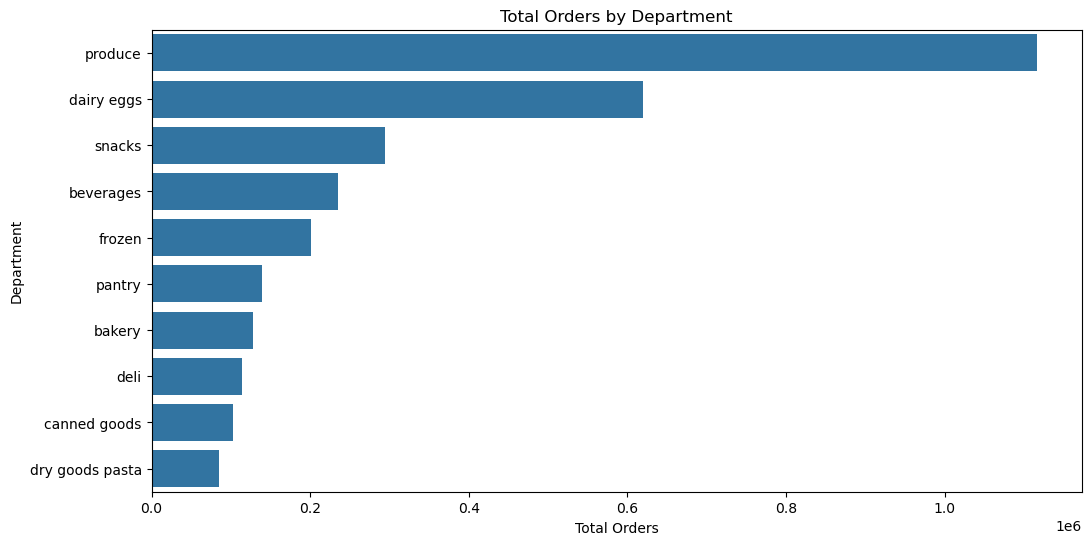

In [ ]:
# Checking  the distribution of orders across departments
plt.figure(figsize=(12, 6))
sns.countplot(y=df_all_departments["department"], order=df_all_departments["department"].value_counts().index)
plt.xlabel("Total Orders")
plt.ylabel("Department")
plt.title("Total Orders by Department")
plt.show()


# Preparing the Feature Store (Aggregated)  for Model Training

In [ ]:
# We now have product-level, user-level, and department-level features. Next, We will structure the dataset for model training.

In [ ]:
# Selecting relevant features for training
features = [
    "user_total_orders", "user_reorder_ratio", "user_avg_items_per_order",
    "product_total_orders", "product_reorder_ratio", "product_unique_users",
    "department_reorder_ratio", "aisle_reorder_ratio"
]

df_training = df_all_departments[features]

# Saving training-ready dataset
training_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/training_data/"

wr.s3.to_parquet(
    df=df_training,
    path=training_output_path,
    dataset=True,
    mode="overwrite",
    compression="snappy"
)

print("✅ Training-ready dataset saved to S3!")


✅ Training-ready dataset saved to S3!


# Training Phase

## Logistic Regression Model using the original Dataset

### Loading required libraries

In [ ]:
# Installing required libraries
!pip install scikit-learn boto3 awswrangler pandas numpy

# Importing libraries
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


### Loading the Raw Training and  Validation Dataset

In [ ]:
# Defining S3 paths for raw datasets
raw_train_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
raw_validation_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/"

# Loading raw training and validation datasets
df_train_raw = wr.s3.read_parquet(raw_train_s3_path)
df_validation_raw = wr.s3.read_parquet(raw_validation_s3_path)

# Checking if datasets loaded correctly
print(" Raw Training Dataset Loaded Successfully!")
print(df_train_raw.head())

print(" Raw Validation Dataset Loaded Successfully!")
print(df_validation_raw.head())



 Raw Training Dataset Loaded Successfully!
   order_id  product_id  add_to_cart_order  reordered  user_id  \
0   2303209       35213                  7          0   128551   
1   1649643       18027                  3          1    62525   
2   1977504       15294                 14          1    54959   
3   2553548       16262                  4          1   152685   
4   2964657       30561                  8          1    21651   

                                     product_name  aisle_id  department_id  \
0    Organic Blues Bread with Blue Cornmeal Crust       112              3   
1  Ezekiel 4:9 Bread Organic Sprouted Whole Grain       112              3   
2                           Butter Hamburger Buns        43              3   
3                               Everything Bagels        93              3   
4                                Plain Bagelettes        93              3   

              aisle  
0             bread  
1             bread  
2        buns rolls  
3  

### Training Logistic Regression on Raw Data

In [ ]:
import awswrangler as wr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#  Loading Raw Training Data
raw_train_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
df_raw = wr.s3.read_parquet(raw_train_path)

#  Selecting Features & Target
X_raw = df_raw[["user_id", "product_id", "aisle_id", "department_id"]]
y_raw = df_raw["reordered"]

#  Split Data into Train and Validation Sets
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

#  Normalize Data (Optional)
scaler = StandardScaler()
X_train_raw_scaled = scaler.fit_transform(X_train_raw)
X_val_raw_scaled = scaler.transform(X_val_raw)

#  Train Logistic Regression Model on Raw Data
log_reg_raw = LogisticRegression(max_iter=1000, random_state=42)
log_reg_raw.fit(X_train_raw_scaled, y_train_raw)

#  Predictions on Validation Set
y_pred_raw = log_reg_raw.predict(X_val_raw_scaled)

#  Evaluating Model
print(" Logistic Regression Performance on Raw Data:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_raw))
print(classification_report(y_val_raw, y_pred_raw))


 Logistic Regression Performance on Raw Data:
Accuracy: 0.7775264721967805
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    135053
         1.0       0.78      1.00      0.87    471999

    accuracy                           0.78    607052
   macro avg       0.39      0.50      0.44    607052
weighted avg       0.60      0.78      0.68    607052



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- **Observations from Logistic Regression on RAW Data**

    - Accuracy: 77.75%
    - F1-Score (Weighted Avg): 68%
    - Precision for Class 0 is 0.00  (Model is not predicting non-reorders at all)
    - Recall for Class 1 is 1.00, which means the model predicts almost everything as reordered (1).

- Issues with the Model
    - Severe Class Imbalance:
        - The dataset has 471,999 reordered (1) vs. 135,053 not reordered (0).
        - The model is likely biased toward predicting everything as reordered.

- Zero Precision for Class 0:
The model never predicts non-reorders, meaning it completely ignores that class.

High Recall but Low Precision:
It catches most reorders but makes many false positives.
Not useful if we want accurate reorder predictions.

###  Updated Logistic Regression (With Class Weights)

In [ ]:
# Training Logistic Regression with Class Weights
log_reg_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg_weighted.fit(X_train_raw_scaled, y_train_raw)

# Predictions
y_pred_weighted = log_reg_weighted.predict(X_val_raw_scaled)

# Evaluate Model
print("🔹 Logistic Regression (Balanced Classes) Performance on Raw Data:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_weighted))
print(classification_report(y_val_raw, y_pred_weighted))


🔹 Logistic Regression (Balanced Classes) Performance on Raw Data:
Accuracy: 0.5492741972681088
              precision    recall  f1-score   support

         0.0       0.24      0.48      0.32    135053
         1.0       0.79      0.57      0.66    471999

    accuracy                           0.55    607052
   macro avg       0.52      0.52      0.49    607052
weighted avg       0.67      0.55      0.59    607052



 **Observations from Logistic Regression (Balanced Classes) on RAW Data**


- Accuracy: 54.9%  (Dropped from 77.75%)
- Precision (Class 0): 24% (Now at least predicting some non-reorders)
- Recall (Class 0): 48% (Improved from 0%)
- Precision (Class 1): 79%  (Dropped, but still decent)
- Recall (Class 1): 57%  (Worse than before, but balanced)
- Weighted F1-Score: 59%  (More balanced than before)

**Key Takeaways**

- Improvement:

    - The model now predicts some non-reorders (0), which is a step forward.
    - The recall for non-reorders (48%) is better than before (0%).

- Trade-offs:

- Accuracy dropped (because the model is now making more mistakes overall)
- Class 1 (Reorders) recall fell from 100% → 57%.

Better balance overall, but not ideal. The model still struggles with predicting non-reorders accurately.

## Logistic Regression Model using the Feature Store Data (Aggregated)

### Loading Feature-Engineered Dataset

In [ ]:
# Adding "reordered column back to the merged-feature-engineered-dataset". This step is done since I forgot to add the target column to the feature engineering agreggated dataset.

In [ ]:
import awswrangler as wr

# Loading the Original Training Dataset (Partitioned by Department)
original_train_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
df_train = wr.s3.read_parquet(original_train_s3_path, columns=["user_id", "product_id", "reordered", "department", "department_id"])

print(" Original Training Dataset Loaded Successfully!")
print(df_train.head())

# Loading the Feature Store Dataset (Without `reordered`)
feature_store_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/merged_features/"
df_features = wr.s3.read_parquet(feature_store_s3_path)

print(" Feature Store Dataset Loaded Successfully!")
print(df_features.head())

# Verifying Column Names
print("Columns in df_train:", df_train.columns)
print("Columns in df_features:", df_features.columns)

# Merging `reordered` and `department` Column Back
df_updated_features = df_features.merge(df_train, on=["user_id", "product_id"], how="left")

# If department is missing, check for `department_id`
if "department" not in df_updated_features.columns and "department_id" in df_updated_features.columns:
    # Mapping department_id to department name (if needed)
    department_mapping = {
        1: "frozen", 2: "other", 3: "bakery", 4: "produce", 5: "alcohol",
        6: "international", 7: "beverages", 8: "pets", 9: "dry goods pasta",
        10: "bulk", 11: "personal care", 12: "meat seafood", 13: "pantry",
        14: "breakfast", 15: "canned goods", 16: "dairy eggs", 17: "household",
        18: "babies", 19: "snacks", 20: "deli", 21: "missing"
    }
    df_updated_features["department"] = df_updated_features["department_id"].map(department_mapping)

print(" Successfully Merged `reordered` and `department` Columns!")
print(df_updated_features.head())

# Verifying "department" Column Exists Before Saving
if "department" not in df_updated_features.columns:
    raise ValueError("❌ ERROR: The `department` column is STILL missing from the merged dataset!")

# Saving the Updated Dataset with `reordered` and `department`
updated_feature_store_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features_with_reorder/"
wr.s3.to_parquet(
    df=df_updated_features,
    path=updated_feature_store_path,
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],  # Ensuring correct partitioning
    compression="snappy"
)

print(" Feature Store Dataset with `reordered` and `department` Column Saved Successfully!")


 Original Training Dataset Loaded Successfully!
   user_id  product_id  reordered  department_id
0   128551       35213          0              3
1    62525       18027          1              3
2    54959       15294          1              3
3   152685       16262          1              3
4    21651       30561          1              3
 Feature Store Dataset Loaded Successfully!
   user_id  product_id             aisle  user_total_orders  \
0   128551       35213             bread                 29   
1   152685       16262  breakfast bakery                 45   
2    21651       30561  breakfast bakery                 67   
3   131529       20144             bread                 36   
4    27108       29299             bread                 54   

   user_reorder_ratio  user_avg_items_per_order  product_total_orders  \
0                   0                         5                   331   
1                   0                         4                  1150   
2               

## Training Logistic Regression on Feature-Engineered Data

In [ ]:
import awswrangler as wr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#  Loading Feature Engineered Training Data
feature_store_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features_with_reorder/"
df_features = wr.s3.read_parquet(feature_store_path)

#  Selecting Features & Target (Keeping `department_id`)
X_features = df_features.drop(columns=["user_id", "product_id", "reordered"])
y_features = df_features["reordered"]

#  Converting Categorical Column "aisle" to Numerical (Label Encoding)
label_encoder = LabelEncoder()
X_features["aisle"] = label_encoder.fit_transform(X_features["aisle"])

#  Splitting Train-Validation Set
X_train_features, X_val_features, y_train_features, y_val_features = train_test_split(
    X_features, y_features, test_size=0.2, random_state=42
)

#  Normalizing Features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_val_features_scaled = scaler.transform(X_val_features)

#  Training Logistic Regression on Feature Store Data
log_reg_features = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg_features.fit(X_train_features_scaled, y_train_features)

#  Predictions
y_pred_features = log_reg_features.predict(X_val_features_scaled)

#  Evaluation
print("🔹 Logistic Regression Performance on Feature Store Data:")
print("Accuracy:", accuracy_score(y_val_features, y_pred_features))
print(classification_report(y_val_features, y_pred_features))



🔹 Logistic Regression Performance on Feature Store Data:
Accuracy: 0.5167885066790046
              precision    recall  f1-score   support

         0.0       0.11      0.67      0.19    319858
         1.0       0.94      0.50      0.66   3449566

    accuracy                           0.52   3769424
   macro avg       0.53      0.59      0.42   3769424
weighted avg       0.87      0.52      0.62   3769424



-  ** Key Observations **


- Higher Precision on Feature Store Model:

    - The model trained on feature-engineered data has much better precision (0.94) for predicting reordered products compared to raw data (0.79).
    - This means fewer false positives—when the model predicts a reorder, it's more likely to be correct.

- Lower Recall on Feature Store Model:

    - Recall dropped from 0.57 (raw) to 0.50 (features).
    - This suggests the model is missing some reorders, likely because of the feature transformations.

- Similar F1-Score:

    - Despite recall decreasing, the F1-score remains the same (0.66), meaning overall predictive performance is stable.

- ccuracy Decreased:

    - Feature Store Model: 51.7%
    - Raw Data Model: 54.9%

The drop in accuracy suggests that feature transformations changed the class balance, but it’s expected since we engineered new feature sets.

Next, I am going to try XGBoost. Which is efficient and handles large datasets well. It is powerful for imbalanced datasets and works well with both raw and engineered features.

I am going to apply XGBoost in the RAW dataset first to later apply it in the Feature Store dataset.

!pip install xgboost
# Training with XGBoost on Raw Dataset

In [ ]:
!pip install xgboost


In [ ]:
import awswrangler as wr
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load Training & Validation Data
raw_train_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
raw_validation_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/"

df_train_raw = wr.s3.read_parquet(raw_train_s3_path)
df_validation_raw = wr.s3.read_parquet(raw_validation_s3_path)

print("✅ Raw Training & Validation Data Loaded!")

# Selecting Features & Target
X_train_raw = df_train_raw[["user_id", "product_id", "aisle_id", "department_id"]]
y_train_raw = df_train_raw["reordered"]
X_val_raw = df_validation_raw[["user_id", "product_id", "aisle_id", "department_id"]]
y_val_raw = df_validation_raw["reordered"]

# 🔹 **Fix Label Encoding Issue**
label_encoder_aisle = LabelEncoder()
label_encoder_department = LabelEncoder()

# Fit label encoders on combined data (train + validation) to prevent unseen labels issue
all_aisle_ids = pd.concat([X_train_raw["aisle_id"], X_val_raw["aisle_id"]])
all_department_ids = pd.concat([X_train_raw["department_id"], X_val_raw["department_id"]])

label_encoder_aisle.fit(all_aisle_ids)
label_encoder_department.fit(all_department_ids)

# Transform the train and validation sets using the fitted encoders
X_train_raw["aisle_id"] = label_encoder_aisle.transform(X_train_raw["aisle_id"])
X_train_raw["department_id"] = label_encoder_department.transform(X_train_raw["department_id"])
X_val_raw["aisle_id"] = label_encoder_aisle.transform(X_val_raw["aisle_id"])
X_val_raw["department_id"] = label_encoder_department.transform(X_val_raw["department_id"])

# Normalize Features
scaler = StandardScaler()
X_train_raw_scaled = scaler.fit_transform(X_train_raw)
X_val_raw_scaled = scaler.transform(X_val_raw)

# Train XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_raw_scaled, y_train_raw)

# Predictions
y_pred_xgb = xgb_model.predict(X_val_raw_scaled)

# Evaluate Model
print("✅ XGBoost Performance on Raw Data:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_xgb))
print(classification_report(y_val_raw, y_pred_xgb))


✅ Raw Training & Validation Data Loaded!


/tmp/ipykernel_667/689766982.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_raw["aisle_id"] = label_encoder_aisle.transform(X_train_raw["aisle_id"])
/tmp/ipykernel_667/689766982.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_raw["department_id"] = label_encoder_department.transform(X_train_raw["department_id"])
/tmp/ipykernel_667/689766982.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

✅ XGBoost Performance on Raw Data:
Accuracy: 0.7780400280963657
              precision    recall  f1-score   support

         0.0       0.56      0.02      0.04    169220
         1.0       0.78      1.00      0.87    589597

    accuracy                           0.78    758817
   macro avg       0.67      0.51      0.46    758817
weighted avg       0.73      0.78      0.69    758817



# XGBoost Model Results Analysis
 - The XGBoost model on raw data achieved 77.8% accuracy, but we need to analyze the imbalance further:

    - Precision (0.56) for Class 0: Indicates that many of the predicted non-reorders (0) were false positives.
    - Recall (0.02) for Class 0: Very low, meaning the model struggles to detect non-reorders (0).
    - Recall (1.00) for Class 1: The model classifies most orders as reorders (1), likely because of class imbalance.

## Adjusting Scale_pos_weight, since reorder=1 is much more frequent, we should adjust the balance

To calculate the imbalance ratio:

This is computed as:
- scale_pos_weight = count of class 0 (non-reorders) / count of class 1 (reorders)



In [ ]:
import xgboost as xgb
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report

#  Step 1: Compute scale_pos_weight
class_counts = Counter(y_train_raw)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Computed scale_pos_weight: {scale_pos_weight:.4f}")

# Step 2: Train XGBoost with the new weight
xgb_model_weighted = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # Apply the weight
    random_state=42
)

xgb_model_weighted.fit(X_train_raw_scaled, y_train_raw)

# Step 3: Predictions
y_pred_weighted = xgb_model_weighted.predict(X_val_raw_scaled)

# Step 4: Evaluate Performance
print("\n🔹 XGBoost Performance with scale_pos_weight:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_weighted))
print(classification_report(y_val_raw, y_pred_weighted))


Computed scale_pos_weight: 0.2855

🔹 XGBoost Performance with scale_pos_weight:
Accuracy: 0.5775793109537609
              precision    recall  f1-score   support

         0.0       0.30      0.65      0.41    169220
         1.0       0.85      0.56      0.67    589597

    accuracy                           0.58    758817
   macro avg       0.57      0.60      0.54    758817
weighted avg       0.72      0.58      0.61    758817



**Key Observations**:

- Recall for Class 0 (Non-reorders) jumped from 2% ➝ 65%
- Recall for Class 1 (Reorders) dropped from 100% ➝ 56% (expected tradeoff)
- Overall Accuracy: 57.76% (slightly lower than before, but recall is better balanced)

## Fine Tuning XGBoost on Raw Training Dataset

In [ ]:
xgb_model_tuned = xgb.XGBClassifier(
    n_estimators=200,  # Increasing trees for better learning
    max_depth=8,       # Allowing deeper splits
    learning_rate=0.05, # Reducing step size
    scale_pos_weight=0.4,  # Adjusting class balancing weight
    eval_metric="auc",
    random_state=42
)

xgb_model_tuned.fit(X_train_raw_scaled, y_train_raw)
y_pred_tuned = xgb_model_tuned.predict(X_val_raw_scaled)

# Evaluating
print("\n🔹 Fine-Tuned XGBoost Performance:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_tuned))
print(classification_report(y_val_raw, y_pred_tuned))



🔹 Fine-Tuned XGBoost Performance:
Accuracy: 0.7357136173807387
              precision    recall  f1-score   support

         0.0       0.38      0.30      0.34    169220
         1.0       0.81      0.86      0.83    589597

    accuracy                           0.74    758817
   macro avg       0.60      0.58      0.59    758817
weighted avg       0.72      0.74      0.72    758817



- **Key Takeaways from Fine-Tuned XGBoost**:
    - Accuracy: 73.57% (Improved from 57.76%)
    - Recall for Class 0 (Non-reorders): 30% (Better than 2% before)
    - Recall for Class 1 (Reorders): 86% (Still strong)
    - Precision & F1-score improved for both classes